<a href="https://colab.research.google.com/github/YuvalPeleg/transformers-workshop/blob/master/TransformerWorkshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Explaining transformer encoders with Language models
===============================================================
In this tutorial we will build (mostly) from scratch the encoder part of the transformer model, and use it to build a [language model](https://en.wikipedia.org/wiki/Language_model)

This tutorial is basically a remix of these excelent tutorials:

[The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) 

[Pytorch- sequence to sequence modeling ](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

Much of the code is taken directly from them.

Another excelent source is [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)

The transormer is based on this [paper](https://arxiv.org/abs/1706.03762) by Google research



<img src='https://github.com/YuvalPeleg/transformers-workshop/blob/master/img/full_model.png?raw=true'>    





In [2]:
import torch

!pip install pytorch_transformers


In [3]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable
import time

# For plots
%matplotlib inline
import matplotlib.pyplot as plt
#Test for cuda device- should be something like 'Tesla K80'
torch.cuda.get_device_name(0)


'Tesla K80'

Building the transformer-encoder
================================

Self Attention
=========
The real meat of the transformer model is the self attention part of it.

From [the illustrated transformer](http://jalammar.github.io/illustrated-transformer/):

"Don’t be fooled by me throwing around the word “self-attention” like it’s a concept everyone should be familiar with. I had personally never came across the concept until reading the Attention is All You Need paper. Let us distill how it works.

Say the following sentence is an input sentence we want to translate:

*”The animal didn't cross the street because it was too tired”*

What does “it” in this sentence refer to? Is it referring to the street or to the animal? It’s a simple question to a human, but not as simple to an algorithm.

When the model is processing the word “it”, self-attention allows it to associate “it” with “animal”.

As the model processes each word (each position in the input sequence), self attention allows it to look at other positions in the input sequence for clues that can help lead to a better encoding for this word.

If you’re familiar with RNNs, think of how maintaining a hidden state allows an RNN to incorporate its representation of previous words/vectors it has processed with the current one it’s processing. Self-attention is the method the Transformer uses to bake the “understanding” of other relevant words into the one we’re currently processing."






#Illustrating self attention

In self attention every token is represented as a weighted sum of all other vectors in the sequence (I ncluding itself)

<img width="300" src="http://jalammar.github.io/images/t/self-attention-matrix-calculation.png">

Every row in the X matrix corresponds to a word in the input sentence. We again see the difference in size of the embedding vector (512, or 4 boxes in the figure), and the q/k/v vectors (64, or 3 boxes in the figure)


We then multiply Wq and Wk.T()
This give us a Seq X Seq matrix in which every Aij in which every cell aij is the weight that the value vector of token j should have for token

<img width="400" src="http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png">

This is then multiplied by the the value matrix to give us the weighted sum


### Calculating Attention                                                                                                                                                                                                                         
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.                                                                                                                                                                                                                                                                                           

We call our particular attention "Scaled Dot-Product Attention".   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.                                                                                                         
<img width="150px" src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png">

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$                     

In [0]:
"""
Calculate self attention.
Arguments
queries: Tensor- Dbatch X nhead X Dseq X head_dim, part one of the weight calculation 
keys: Tensor- Dbatch X nhead X Dseq X head_dim, part one of the weight calculation 
values: Tensor- Dbatch X nhead X Dseq X head_dim, values to sum weights on 
mask: Tensor- Dseq X Dseq, zeros will not be attended
"""
def calculatue_attention(queries, keys, values, mask, dropout):
    head_dim = queries.shape[3]
    #keys * queries.T * values
    #Dbatch X nhead X Dseq X head_dim    
    weights = torch.matmul(queries, keys.transpose(-2, -1))
    #Dbatch X nhead X Dseq D X Dseq D
    weights_scaled = weights / math.sqrt(head_dim)
    if mask is not None:
        weights_scaled = weights_scaled.masked_fill(mask == 0, -1e9)
    weights_normed = F.softmax(weights_scaled, dim = -1)
    if dropout:
      weights_normed = F.dropout(weights_normed)
    attended_keys = torch.matmul(weights_normed, values)
    #Dbatch X nhead X Dseq D X head_dim
    return attended_keys

A bit on masking:
We will use masking to make sure the model uses only previous tokens for prediction


In [0]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

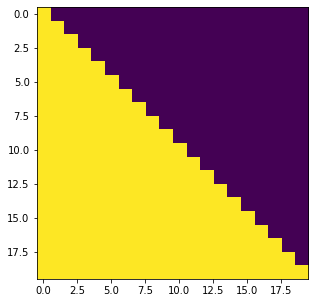

In [6]:
# The attention mask shows the position each tgt word (row) is allowed to look at (column).
# Words are blocked for attending to future words during training. 
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

### Building the multi-head attention layer
# Multi-Head Attention                                                                                                                                                                                        
Instead of performing a single attention function with $d_{\text{model}}$-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values $h$ times with different, learned linear projections to $d_k$, $d_k$ and $d_v$ dimensions, respectively.                                                                                                                                                                                                   
On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values. These are concatenated and once again projected, resulting in the final values:

<img width="270px" src="https://nlp.seas.harvard.edu/images/ModalNet-20.png">
                                                                                                                                      
**Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions.** With a single attention head, averaging inhibits this.            
In other words, this allows different features to attend to other words.
For example: 

<img width="270px" src="http://jalammar.github.io/images/t/transformer_self-attention_visualization_2.png">

Let's do a little excercize:
This is ExBert which is a framework for visualizing BERT:

http://exbert.net/exBERT.html

We can see how the attention heads are affecting the prediction by turning them on and off


<img width="200px" src="https://github.com/YuvalPeleg/transformers-workshop/blob/master/img/multihead.png?raw=true">




In [7]:
import pdb; 
class MyMultiHeadAttention(nn.Module):
  def __init__(self, embed_dim, nhead, dropout):
    super(MyMultiHeadAttention, self).__init__()
    if do_print:
      print("MyMultiHeadAttention _init")
    self.embed_dim = embed_dim
    self.nhead = nhead
    self.dropout = dropout
    self.queries_linear = nn.Linear(embed_dim, embed_dim)
    self.keys_linear = nn.Linear(embed_dim, embed_dim)
    self.values_linear = nn.Linear(embed_dim, embed_dim)
    self.final_linear = nn.Linear(embed_dim, embed_dim)
    self.head_dim = embed_dim // nhead

  """
  sequence_batch: Dseq X Dbatch D X embed_dim
  keys, values: duplicates of sequence_batch, here for compatibility reasons
  attn_max: a Dseq X Dseq matrix 

  """  
  def forward(self, sequence_batch, keys, values, attn_mask=None):
    "Implements Figure 2"
    #Sequence: Dseq X Dbatch D X embed_dim
    sequence_batch = sequence_batch.transpose(0, 1)
    #Sequence: Dbatch X DbatchDseq D X embed_dim
    #pdb.set_trace()    
    batch_size = sequence_batch.size(0)
    queries, keys, values = [linear(sequence_batch) for linear in [self.queries_linear, self.keys_linear, self.values_linear]]
    #divide into attention heads:
    #Dbatch X nhead X Dseq D X head_dim
    queries, keys, values = [attention_part.view(batch_size, -1, self.nhead, self.head_dim).transpose(1,2) for attention_part in [queries, keys, values]]
    attended_heads = calculatue_attention(queries, keys, values, attn_mask, self.dropout)
    #concat heads back to 
    #Dbatch X Dseq D X embed_dim
    #
    if do_print:
      print("attended_heads.shape:" + str(attended_heads.shape))
    concated_heads = attended_heads.transpose(1, 2)\
    .contiguous()\
    .view(batch_size, -1, self.embed_dim)
    concated_result = self.final_linear(concated_heads) # 
    return concated_result.transpose(0,1)
  


def test_multi_head_attention():
  attention = MyMultiHeadAttention(50, 5, 0.1)
  mock_batch = torch.randn((5, 10, 50))
  result = attention(mock_batch, mock_batch, mock_batch, attn_mask =None)
  print(result.size())
do_print=False
test_multi_head_attention()

torch.Size([5, 10, 50])


#Encoder
The encoder holds N layers. It runs them sequantially, and normalizes each layer

<img src='https://github.com/YuvalPeleg/transformers-workshop/blob/master/img/encoder_diagram.png?raw=true' width=200px>


In [0]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

#Encoder Layer
Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.


<img src='https://github.com/YuvalPeleg/transformers-workshop/blob/master/img/encoder_layer.png?raw=true' width=200px>



In [0]:
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):    
        "Follow Figure 1 (left) for connections."        
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, attn_mask=mask)[0])
        return self.sublayer[1](x, self.feed_forward)

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout [(cite)](srivastava2014dropout) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

<img src='https://github.com/YuvalPeleg/transformers-workshop/blob/master/img/sublayer.png?raw=true' width=200px>

In [0]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."       
        return x + self.dropout(sublayer(self.norm(x)))

In [0]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

## Position-wise Feed-Forward Networks                                                                                                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.  This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                        
While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$. 

<img src='https://github.com/YuvalPeleg/transformers-workshop/blob/master/img/feed_forward.png?raw=true' width=200px>

In [0]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


We employ a residual connection [(cite)](he2016deep) around each of the two sub-layers, followed by layer normalization [(cite)](layernorm2016).  

## Positional Encoding                                                            
<img src="http://jalammar.github.io/images/t/transformer_positional_encoding_vectors.png" width=800 />

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed [(cite)](JonasFaceNet2017). 

In this work, we use sine and cosine functions of different frequencies:                                                                                                                                                                                                                      *italicized text*                                                                                                                                                                                                                                                                                                            
$$                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \\                                                                                                                                                                                                                                                                                                                                                                                                                                      
    PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})                                                                                                                                                                                                                                                                                                                                                                                                                                       
$$                                                                                                                                                                                                                                                        
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. 

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$. 

This [blog post](https://timodenk.com/blog/linear-relationships-in-the-transformers-positional-encoding/) explains why this works                                                                                                                                                                                          

<img src='https://github.com/YuvalPeleg/transformers-workshop/blob/master/img/positional_encoding.png?raw=true' width=200px>                                                       


In [0]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

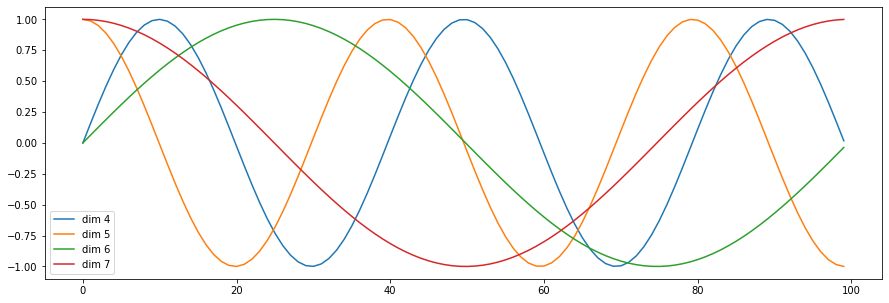

In [14]:
# The positional encoding will add in a sine wave based on position.
# The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

In [0]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable
import time

# For plots
%matplotlib inline
import matplotlib.pyplot as plt

Putting it all together
======================
<img src='https://github.com/YuvalPeleg/transformers-workshop/blob/master/img/full_model.png?raw=true' width=200px>    

In [0]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModelFromScratchAttention(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModelFromScratchAttention, self).__init__()
        print("miao")
        #from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)

        c = copy.deepcopy
     
        attn = MyMultiHeadAttention(ninp, nhead, dropout)    
        ff  = PositionwiseFeedForward(ninp, nhid, dropout)

        self.transformer_encoder = Encoder(EncoderLayer(ninp, c(attn), c(ff), dropout), nlayers)
                
        self.embedder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.embedder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.embedder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

Load and batch the data
========================
The training process uses Wikitext-2 dataset from ``torchtext``.

The [WikiText](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/#) language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia. 

It is basically a long list of tokens.

The vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Starting from sequential data, the ``batchify()``
function arranges the dataset into columns, trimming off any tokens remaining
after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26)
and a batch size of 4, we would divide the alphabet into 4 sequences of
length 6:

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

These columns are treated as independent by the model, which means that
the dependence of ``G`` and ``F`` can not be learned, but allows more
efficient batch processing.

The structure of the resulting data set would be
a 
Nbatches X Ntokens/Nbatches matrix with each cell holding an ID corresponding to a string in the vocabulary






In [0]:
import torchtext
from torchtext.data.utils import get_tokenizer
TEXT = torchtext.data.Field(tokenize=get_tokenizer("spacy"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

Training the model
====================






```
# This is formatted as code
```

``get_batch()`` function generates the input and target sequence for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

![](https://github.com/pytorch/tutorials/blob/master/_static/img/transformer_input_target.png?raw=true)


It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.

In other words:
For each subsequence in the original text the target to it will be the following word:

Lets say we have the sequence "I like cats very much" the data will pretty much be a represenation of:

**Input**          **Target** 

"I"                  "like"

"I like"           "cats"

"I like cats" "very"




In [18]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

data, targets = get_batch(train_data, 0) 
print("Data shape: " + str(data.shape))
print("Data shape: " + str(targets.shape))

Data shape: torch.Size([35, 20])
Data shape: torch.Size([700])


This splits input data into sort ngrams of size bptt (35) here.
For each such ngram the target it the word following it in the text.

We use [CrossEntropyLoss](https://pytorch.org/docs/master/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss>) as loss function
is applied to track the loss and [SGD](https://pytorch.org/docs/master/optim.html?highlight=sgd#torch.optim.SGD) implements stochastic gradient descent method as the optimizer. 
The initial learning rate is set to 5.0. [StepLR](https://pytorch.org/docs/master/optim.html?highlight=steplr#torch.optim.lr_scheduler.StepLR) is
applied to adjust the learn rate through epochs. 
During the training, we use
[nn.utils.clip_grad_norm](https://pytorch.org/docs/master/nn.html?highlight=nn%20utils%20clip_grad_norm#torch.nn.utils.clip_grad_norm_)
function to scale all the gradient together to prevent exploding.

In [0]:
import time
def train(model):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        #data -> [seqlen X nbatch] torch.Size([35, 20])
        #targets -> [nbatch * seqlen] torch.Size([700]
        data, targets = get_batch(train_data, i)
        #print(data[0:])
        optimizer.zero_grad()
        # print(data.shape)
        # print(targets.shape)
        output = model(data)
        #print(output.shape)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        #print(model.encoder.weight)
        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    return model

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode, this is important as it turns dropout off
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)


Loop over epochs. Save the model if the validation loss is th
e best
we've seen so far. Adjust the learning rate after each epoch.

In [20]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the life dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
do_print = False
model = TransformerModelFromScratchAttention(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)


best_val_loss = float("inf")
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    model = train(model)    
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

miao
| epoch   1 |   200/ 3195 batches | lr 5.00 | ms/batch 41.92 | loss  6.90 | ppl   992.45
| epoch   1 |   400/ 3195 batches | lr 5.00 | ms/batch 41.56 | loss  6.02 | ppl   410.58
| epoch   1 |   600/ 3195 batches | lr 5.00 | ms/batch 41.54 | loss  5.76 | ppl   316.99
| epoch   1 |   800/ 3195 batches | lr 5.00 | ms/batch 41.45 | loss  5.56 | ppl   260.68
| epoch   1 |  1000/ 3195 batches | lr 5.00 | ms/batch 41.31 | loss  5.58 | ppl   265.93
| epoch   1 |  1200/ 3195 batches | lr 5.00 | ms/batch 41.46 | loss  5.51 | ppl   246.40
| epoch   1 |  1400/ 3195 batches | lr 5.00 | ms/batch 41.27 | loss  5.47 | ppl   237.49
| epoch   1 |  1600/ 3195 batches | lr 5.00 | ms/batch 41.26 | loss  5.37 | ppl   215.10
| epoch   1 |  1800/ 3195 batches | lr 5.00 | ms/batch 41.40 | loss  5.37 | ppl   214.77
| epoch   1 |  2000/ 3195 batches | lr 5.00 | ms/batch 41.23 | loss  5.35 | ppl   211.45
| epoch   1 |  2200/ 3195 batches | lr 5.00 | ms/batch 41.31 | loss  5.28 | ppl   196.10
| epoch   1 |  2

In [21]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  4.31 | test ppl    74.29


### Calculating Attention                                                                                                                                                                                                                         
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.                                                                                                                                                                                                                                                                                           

We call our particular attention "Scaled Dot-Product Attention".   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.                                                                                                         
<img width="150px" src="https://nlp.seas.harvard.edu/images/the-annotated-transformer_33_0.png">

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$                     

In [0]:
"""
Calculate self attention.
Arguments
queries: Tensor- Dbatch X nhead X Dseq X head_dim, part one of the weight calculation 
keys: Tensor- Dbatch X nhead X Dseq X head_dim, part one of the weight calculation 
values: Tensor- Dbatch X nhead X Dseq X head_dim, values to sum weights on 
mask: Tensor- Dseq X Dseq, zeros will not be attended
"""
def your_calculatue_attention(queries, keys, values, mask, dropout):
    head_dim = queries.shape[3]
    #keys * queries.T * values
    #Dbatch X nhead X Dseq X head_dim    
    weights = None #your code here
    #Dbatch X nhead X Dseq D X Dseq D
    weights_scaled = None #your code here
    if mask is not None:
        weights_scaled = weights_scaled.masked_fill(mask == 0, -1e9)
    weights_normed = F.softmax(weights_scaled, dim = -1)
    if dropout:
      weights_normed = F.dropout(weights_normed)
    attended_keys = None #your code here
    #Dbatch X nhead X Dseq D X head_dim
    return attended_keys